/opt/anaconda3/envs/research/lib/python3.11/site-packages/gstools/field/plot.py:406: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Field 2D structured: (100, 100)'}, xlabel='$x$', ylabel='$y$'>

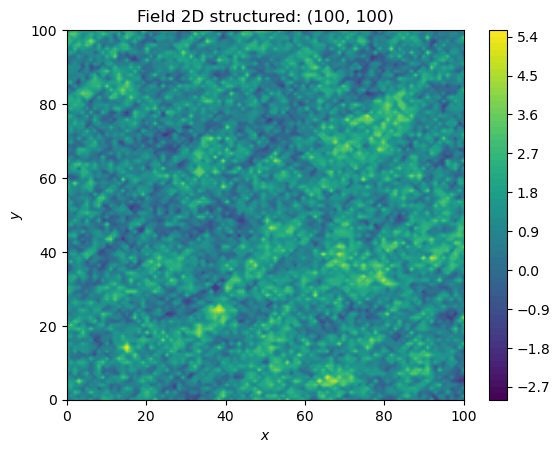

In [1]:
r"""
Truncated Power Law Variograms
------------------------------

GSTools also implements truncated power law variograms,
which can be represented as a superposition of scale dependant modes
in form of standard variograms, which are truncated by
a lower- :math:`\ell_{\mathrm{low}}` and
an upper length-scale :math:`\ell_{\mathrm{up}}`.

This example shows the truncated power law (:any:`TPLStable`) based on the
:any:`Stable` covariance model and is given by

.. math::
   \gamma_{\ell_{\mathrm{low}},\ell_{\mathrm{up}}}(r) =
   \intop_{\ell_{\mathrm{low}}}^{\ell_{\mathrm{up}}}
   \gamma(r,\lambda) \frac{\rm d \lambda}{\lambda}

with `Stable` modes on each scale:

.. math::
   \gamma(r,\lambda) &=
   \sigma^2(\lambda)\cdot\left(1-
   \exp\left[- \left(\frac{r}{\lambda}\right)^{\alpha}\right]
   \right)\\
   \sigma^2(\lambda) &= C\cdot\lambda^{2H}

which gives Gaussian modes for ``alpha=2``
or Exponential modes for ``alpha=1``.

For :math:`\ell_{\mathrm{low}}=0` this results in:

.. math::
   \gamma_{\ell_{\mathrm{up}}}(r) &=
   \sigma^2_{\ell_{\mathrm{up}}}\cdot\left(1-
   \frac{2H}{\alpha} \cdot
   E_{1+\frac{2H}{\alpha}}
   \left[\left(\frac{r}{\ell_{\mathrm{up}}}\right)^{\alpha}\right]
   \right) \\
   \sigma^2_{\ell_{\mathrm{up}}} &=
   C\cdot\frac{\ell_{\mathrm{up}}^{2H}}{2H}
"""
import numpy as np

import gstools as gs

x = y = np.linspace(0, 100, 100)
model = gs.TPLStable(
    dim=2,  # spatial dimension
    var=1,  # variance (C is calculated internally, so variance is actually 1)
    len_low=0,  # lower truncation of the power law
    len_scale=10,  # length scale (a.k.a. range), len_up = len_low + len_scale
    nugget=0.1,  # nugget
    anis=0.5,  # anisotropy between main direction and transversal ones
    angles=np.pi / 4,  # rotation angles
    alpha=1.5,  # shape parameter from the stable model
    hurst=0.7,  # hurst coefficient from the power law
)
srf = gs.SRF(model, mean=1.0, seed=19970221)
srf.structured([x, y])
srf.plot()


In [2]:
"""
Exporting Fields
----------------

GSTools provides simple exporting routines to convert generated fields to
`VTK <https://vtk.org/>`__ files.

These can be viewed for example with `Paraview <https://www.paraview.org/>`__.
"""
# sphinx_gallery_thumbnail_path = 'pics/paraview.png'
import gstools as gs

x = y = range(100)
model = gs.Gaussian(dim=2, var=1, len_scale=10)
srf = gs.SRF(model)
field = srf((x, y), mesh_type="structured")
srf.vtk_export(filename="field")

###############################################################################
# The result displayed with Paraview:
#
# .. image:: https://raw.githubusercontent.com/GeoStat-Framework/GeoStat-Framework.github.io/master/img/paraview.png
#    :width: 400px
#    :align: center


'/Users/cui/Documents/GitHub/GSTools/examples/field.vtr'

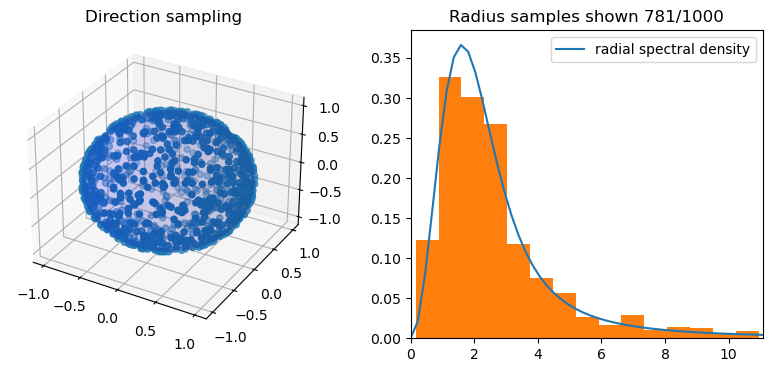

In [3]:
"""
Check Random Sampling
---------------------
"""
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import gstools as gs


def norm_rad(vec):
    """Direction on the unit sphere."""
    vec = np.array(vec, ndmin=2)
    norm = np.zeros(vec.shape[1])
    for i in range(vec.shape[0]):
        norm += vec[i] ** 2
    norm = np.sqrt(norm)
    return np.einsum("j,ij->ij", 1 / norm, vec), norm


def plot_rand_meth_samples(generator):
    """Plot the samples of the rand meth class."""
    norm, rad = norm_rad(generator._cov_sample)

    fig = plt.figure(figsize=(10, 4))

    if generator.model.dim == 3:
        ax = fig.add_subplot(121, projection=Axes3D.name)
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, rstride=4, cstride=4, color="b", alpha=0.1)
        ax.scatter(norm[0], norm[1], norm[2])
    elif generator.model.dim == 2:
        ax = fig.add_subplot(121)
        u = np.linspace(0, 2 * np.pi, 100)
        x = np.cos(u)
        y = np.sin(u)
        ax.plot(x, y, color="b", alpha=0.1)
        ax.scatter(norm[0], norm[1])
        ax.set_aspect("equal")
    else:
        ax = fig.add_subplot(121)
        ax.bar(-1, np.sum(np.isclose(norm, -1)), color="C0")
        ax.bar(1, np.sum(np.isclose(norm, 1)), color="C0")
        ax.set_xticks([-1, 1])
        ax.set_xticklabels(("-1", "1"))
    ax.set_title("Direction sampling")

    ax = fig.add_subplot(122)
    x = np.linspace(0, 10 / generator.model.integral_scale)
    y = generator.model.spectral_rad_pdf(x)
    ax.plot(x, y, label="radial spectral density")
    sample_in = np.sum(rad <= np.max(x))
    ax.hist(rad[rad <= np.max(x)], bins=sample_in // 50, density=True)
    ax.set_xlim([0, np.max(x)])
    ax.set_title(f"Radius samples shown {sample_in}/{len(rad)}")
    ax.legend()
    plt.show()


model = gs.Stable(dim=3, alpha=1.5)
srf = gs.SRF(model, seed=2020)
plot_rand_meth_samples(srf.generator)


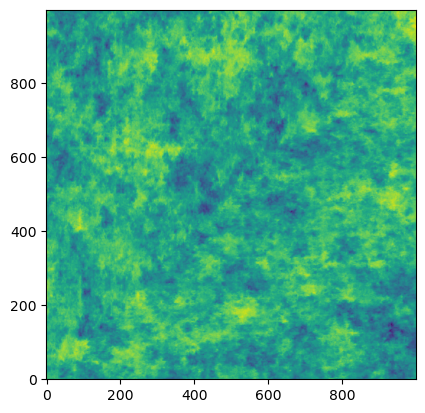

In [ ]:
"""
Analyzing the Herten Aquifer with GSTools
-----------------------------------------

This example is going to be a bit more extensive and we are going to do some
basic data preprocessing for the actual variogram estimation. But this example
will be self-contained and all data gathering and processing will be done in
this example script.


The Data
^^^^^^^^

We are going to analyse the Herten aquifer, which is situated in Southern
Germany. Multiple outcrop faces where surveyed and interpolated to a 3D
dataset. In these publications, you can find more information about the data:

| Bayer, Peter; Comunian, Alessandro; Höyng, Dominik; Mariethoz, Gregoire (2015): Physicochemical properties and 3D geostatistical simulations of the Herten and the Descalvado aquifer analogs. PANGAEA, https://doi.org/10.1594/PANGAEA.844167,
| Supplement to: Bayer, P et al. (2015): Three-dimensional multi-facies realizations of sedimentary reservoir and aquifer analogs. Scientific Data, 2, 150033, https://doi.org/10.1038/sdata.2015.33
|

Retrieving the Data
^^^^^^^^^^^^^^^^^^^

To begin with, we need to download and extract the data. Therefore, we are
going to use some built-in Python libraries. For simplicity, many values and
strings will be hardcoded.

You don't have to execute the ``download_herten`` and ``generate_transmissivity``
functions, since the only produce the ``herten_transmissivity.gz``
and ``grid_dim_origin_spacing.txt``, which are already present.
"""
import os

import matplotlib.pyplot as plt
import numpy as np

import gstools as gs

VTK_PATH = os.path.join("Herten-analog", "sim-big_1000x1000x140", "sim.vtk")

###############################################################################


def download_herten():
    """Download the data, warning: its about 250MB."""
    import urllib.request
    import zipfile

    print("Downloading Herten data")
    data_filename = "data.zip"
    data_url = (
        "http://store.pangaea.de/Publications/"
        "Bayer_et_al_2015/Herten-analog.zip"
    )
    urllib.request.urlretrieve(data_url, "data.zip")
    # extract the "big" simulation
    with zipfile.ZipFile(data_filename, "r") as zf:
        zf.extract(VTK_PATH)


###############################################################################


def generate_transmissivity():
    """Generate a file with a transmissivity field from the HERTEN data."""
    import shutil

    import pyvista as pv

    print("Loading Herten data with pyvista")
    mesh = pv.read(VTK_PATH)
    herten = mesh.point_data["facies"].reshape(mesh.dimensions, order="F")
    # conductivity values per fazies from the supplementary data
    cond = 1e-4 * np.array(
        [2.5, 2.3, 0.61, 260, 1300, 950, 0.43, 0.006, 23, 1.4]
    )
    # asign the conductivities to the facies
    herten_cond = cond[herten]
    # Next, we are going to calculate the transmissivity,
    # by integrating over the vertical axis
    herten_trans = np.sum(herten_cond, axis=2) * mesh.spacing[2]
    # saving some grid informations
    grid = [mesh.dimensions[:2], mesh.origin[:2], mesh.spacing[:2]]
    print("Saving the transmissivity field and grid information")
    np.savetxt("herten_transmissivity.gz", herten_trans)
    np.savetxt("grid_dim_origin_spacing.txt", grid)
    # Some cleanup. You can comment out these lines to keep the downloaded data
    os.remove("data.zip")
    shutil.rmtree("Herten-analog")


###############################################################################
# Downloading and Preprocessing
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# You can uncomment the following two calls, so the data is downloaded
# and processed again.

# download_herten()
# generate_transmissivity()


###############################################################################
# Analyzing the data
# ^^^^^^^^^^^^^^^^^^
#
# The Herten data provides information about the grid, which was already used in
# the previous code block. From this information, we can create our own grid on
# which we can estimate the variogram. As a first step, we are going to estimate
# an isotropic variogram, meaning that we will take point pairs from all
# directions into account. An unstructured grid is a natural choice for this.
# Therefore, we are going to create an unstructured grid from the given,
# structured one. For this, we are going to write another small function

herten_log_trans = np.log(np.loadtxt("herten_transmissivity.gz"))
dim, origin, spacing = np.loadtxt("grid_dim_origin_spacing.txt")

# create a structured grid on which the data is defined
x_s = np.arange(origin[0], origin[0] + dim[0] * spacing[0], spacing[0])
y_s = np.arange(origin[1], origin[1] + dim[1] * spacing[1], spacing[1])
# create the corresponding unstructured grid for the variogram estimation
x_u, y_u = np.meshgrid(x_s, y_s)


###############################################################################
# Let's have a look at the transmissivity field of the Herten aquifer

plt.imshow(herten_log_trans.T, origin="lower", aspect="equal")
plt.show()


###############################################################################
# Estimating the Variogram
# ^^^^^^^^^^^^^^^^^^^^^^^^
#
# Finally, everything is ready for the variogram estimation. For the unstructured
# method, we have to define the bins on which the variogram will be estimated.
# Through expert knowledge (i.e. fiddling around), we assume that the main
# features of the variogram will be below 10 metres distance. And because the
# data has a high spatial resolution, the resolution of the bins can also be
# high. The transmissivity data is still defined on a structured grid, but we can
# simply flatten it with :any:`numpy.ndarray.flatten`, in order to bring it into
# the right shape. It might be more memory efficient to use
# ``herten_log_trans.reshape(-1)``, but for better readability, we will stick to
# :any:`numpy.ndarray.flatten`. Taking all data points into account would take a
# very long time (expert knowledge \*wink\*), thus we will only take 2000 datapoints into account, which are sampled randomly. In order to make the exact
# results reproducible, we can also set a seed.


bins = gs.standard_bins(pos=(x_u, y_u), max_dist=10)
bin_center, gamma = gs.vario_estimate(
    (x_u, y_u),
    herten_log_trans.reshape(-1),
    bins,
    sampling_size=2000,
    sampling_seed=19920516,
)

###############################################################################
# The estimated variogram is calculated on the centre of the given bins,
# therefore, the ``bin_center`` array is also returned.

###############################################################################
# Fitting the Variogram
# ^^^^^^^^^^^^^^^^^^^^^
#
# Now, we can see, if the estimated variogram can be modelled by a common
# variogram model. Let's try the :any:`Exponential` model.

# fit an exponential model
fit_model = gs.Exponential(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)

###############################################################################
# Finally, we can visualise some results. For quickly plotting a covariance
# model, GSTools provides some helper functions.

ax = fit_model.plot(x_max=max(bin_center))
ax.plot(bin_center, gamma)


###############################################################################
# That looks like a pretty good fit! By printing the model, we can directly see
# the fitted parameters

print(fit_model)

###############################################################################
# With this data, we could start generating new ensembles of the Herten aquifer
# with the :any:`SRF` class.


###############################################################################
# Estimating the Variogram in Specific Directions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Estimating a variogram on a structured grid gives us the possibility to only
# consider values in a specific direction. This could be a first test, to see if
# the data is anisotropic.
# In order to speed up the calculations, we are going to only use every 10th datapoint and for a comparison with the isotropic variogram calculated earlier, we
# only need the first 21 array items.


# estimate the variogram on a structured grid
# use only every 10th value, otherwise calculations would take very long
x_s_skip = np.ravel(x_s)[::10]
y_s_skip = np.ravel(y_s)[::10]
herten_trans_skip = herten_log_trans[::10, ::10]

###############################################################################
# With this much smaller data set, we can immediately estimate the variogram in
# the x- and y-axis

gamma_x = gs.vario_estimate_axis(herten_trans_skip, direction="x")
gamma_y = gs.vario_estimate_axis(herten_trans_skip, direction="y")

###############################################################################
# With these two estimated variograms, we can start fitting :any:`Exponential`
# covariance models

x_plot = x_s_skip[:21]
y_plot = y_s_skip[:21]
# fit an exponential model
fit_model_x = gs.Exponential(dim=2)
fit_model_x.fit_variogram(x_plot, gamma_x[:21], nugget=False)
fit_model_y = gs.Exponential(dim=2)
fit_model_y.fit_variogram(y_plot, gamma_y[:21], nugget=False)

###############################################################################
# Now, the isotropic variogram and the two variograms in x- and y-direction can
# be plotted together with their respective models, which will be plotted with
# dashed lines.

plt.figure()  # new figure
(line,) = plt.plot(bin_center, gamma, label="estimated variogram (isotropic)")
plt.plot(
    bin_center,
    fit_model.variogram(bin_center),
    color=line.get_color(),
    linestyle="--",
    label="exp. variogram (isotropic)",
)

(line,) = plt.plot(x_plot, gamma_x[:21], label="estimated variogram in x-dir")
plt.plot(
    x_plot,
    fit_model_x.variogram(x_plot),
    color=line.get_color(),
    linestyle="--",
    label="exp. variogram in x-dir",
)

(line,) = plt.plot(y_plot, gamma_y[:21], label="estimated variogram in y-dir")
plt.plot(
    y_plot,
    fit_model_y.variogram(y_plot),
    color=line.get_color(),
    linestyle="--",
    label="exp. variogram in y-dir",
)

plt.legend()
plt.show()

###############################################################################
# The plot might be a bit cluttered, but at least it is pretty obvious that the
# Herten aquifer has no apparent anisotropies in its spatial structure.

print("semivariogram model (isotropic):\n", fit_model)
print("semivariogram model (in x-dir.):\n", fit_model_x)
print("semivariogram model (in y-dir.):\n", fit_model_y)


###############################################################################
# Creating a Spatial Random Field from the Herten Parameters
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# With all the hard work done, it's straight forward now, to generate new
# *Herten-like realisations*

# create a spatial random field on the low-resolution grid
srf = gs.SRF(fit_model, seed=19770928)
srf.structured([x_s_skip, y_s_skip])
ax = srf.plot()
ax.set_aspect("equal")

###############################################################################
# That's pretty neat!


In [ ]:
"""
Standalone Field class
----------------------

The :any:`Field` class of GSTools can be used to plot arbitrary data in nD.

In the following example we will produce 10000 random points in 4D with
random values and plot them.
"""
import numpy as np

import gstools as gs

rng = np.random.RandomState(19970221)
x0 = rng.rand(10000) * 100.0
x1 = rng.rand(10000) * 100.0
x2 = rng.rand(10000) * 100.0
x3 = rng.rand(10000) * 100.0
values = rng.rand(10000) * 100.0

###############################################################################
# Only thing needed to instantiate the Field is the dimension.
#
# Afterwards we can call the instance like all other Fields
# (:any:`SRF`, :any:`Krige` or :any:`CondSRF`), but with an additional field.

plotter = gs.field.Field(dim=4)
plotter(pos=(x0, x1, x2, x3), field=values)
plotter.plot()
